In [1]:
%load_ext autoreload
%autoreload 2 

### One Shot Transfer Learning for Van der Pols Oscillator
$$
\begin{align*}
\frac{dx}{dt} &= y ,\quad \frac{dy}{dt} &= \alpha(1 - x^2)y - x
\end{align*}
$$
with initial conditions $x_0=2$ and $y_0=0$ and $\alpha>1$ the stiffness parameter.

After rescaling $\tilde{x} = \frac{x}{\lambda}$ and $\tilde{y} = \frac{y}{\lambda}$ with $0<\lambda<1$
$$
\begin{align*}
\frac{d\tilde{x}}{dt} &= \tilde{y} ,\quad \frac{d\tilde{y}}{dt} &= \alpha(1 - \lambda^2\tilde{x}^2)\tilde{y} - \tilde{x} = \alpha\tilde{y} - \tilde{x} - \alpha\lambda^2\tilde{x}^2\tilde{y}
\end{align*}
$$
with initial conditions $x_0= \frac{2}{\lambda}$ and $y_0=\frac{0}{\lambda}=0$

Then by $\lambda$-perturbation expansion $\tilde{x}=\sum_{i=0}^{\infty}\lambda^iX_i$ and $\tilde{y}=\sum_{i=0}^{\infty}\lambda^iY_i$ with have these systems for the various power of $\lambda^i$ with $i=0, 1, 2, ...$
$$
\begin{align*}
\frac{dX_i}{dt} - Y_i &= 0, \quad \frac{dY_i}{dt} - \alpha Y_i + X_i &= f_i \\
\end{align*} \\
\begin{align*}
f_i = \begin{cases}
0 \ \text{for} \ i \in \{0, 1\} \\
-\alpha\sum_{a+b+c=i-2}^{0<a,b,c<p}\phi(a,b,c)x_ax_by_c \ \ \text{with} \ \phi(a,b,c)=\begin{cases}
1 \ \text{if} \ a=b \\
2 \ \text{otherwise}
\end{cases}
\end{cases}
\end{align*}
$$

So these are linear system with A = $
\begin{bmatrix}
  0 & -1 \\
  1 & -\alpha 
\end{bmatrix}
$ and f = $\begin{bmatrix}
  0 \\
  f_i 
\end{bmatrix}$


### One Shot Transfer Learning for modified Van der Pols Oscillator
$$
\begin{align*}
\frac{dx}{dt} &= y ,\quad \frac{dy}{dt} &= \alpha(1 - \beta x^2)y - x
\end{align*}
$$
with initial conditions $x_0=2$ and $y_0=0$ and $\alpha>1$ the stiffness parameter.

Then by $\beta$-perturbation expansion $\tilde{x}=\sum_{i=0}^{\infty}\beta^iX_i$ and $\tilde{y}=\sum_{i=0}^{\infty}\beta^iY_i$ with have these systems for the various power of $\beta^i$ with $i=0, 1, 2, ...$
$$
\begin{align*}
\frac{dX_i}{dt} - Y_i &= 0, \quad \frac{dY_i}{dt} - \alpha Y_i + X_i &= f_i \\
\end{align*} \\
\begin{align*}
f_i = \begin{cases}
0 \ \text{for} \ i \in \{0\} \\
-\alpha\sum_{a+b+c=i-1}^{0<a,b,c<p}\phi(a,b,c)x_ax_by_c \ \ \text{with} \ \phi(a,b,c)=\begin{cases}
1 \ \text{if} \ a=b \\
2 \ \text{otherwise}
\end{cases}
\end{cases}
\end{align*}
$$

So these are linear system with A = $
\begin{bmatrix}
  0 & -1 \\
  1 & -\alpha 
\end{bmatrix}
$ and f = $\begin{bmatrix}
  0 \\
  f_i 
\end{bmatrix}$


In [1]:
# imports
import torch
import matplotlib.pyplot as plt
import numpy as np
import sys
from scipy.integrate import solve_ivp

# Add parent directory to sys.path
from pathlib import Path
current_path = Path.cwd()
parent_dir = current_path.parent
sys.path.append(str(parent_dir))
sys.path.append(str(parent_dir.joinpath("linearODE")))

# Import necessary modules
from src.train import run_model_new
from src.utils_plot import plot_loss_and_all_solution, plot_head_loss
from src.load_save import save_model

torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [3]:
def check_versions_and_device():
  # set the device to the GPU if it is available, otherwise use the CPU
  current_dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  !nvidia-smi
  return current_dev

# set a global device variable to use in code
dev = check_versions_and_device()
print(dev)

Wed Jan 10 18:55:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 537.13                 Driver Version: 537.13       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050      WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   43C    P8              N/A / ERR! |   1974MiB /  2048MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [61]:
num_heads = 10

np.random.seed(42)
# generate the training stiffness parameter alpha
alpha_bounds = (1, 3)
def generate_alpha(k, alpha_bounds = alpha_bounds):
  alpha_list = np.zeros(k)
  for i in range(k):
    alpha_list[i] = np.random.uniform(alpha_bounds[0], alpha_bounds[1])
  return alpha_list
alpha_list = generate_alpha(num_heads)

# create the A matrix associated with the ODE
def get_A(alpha):
    return torch.tensor([[0., -1], [1, -alpha]], device=dev).double() 
A_list = [get_A(i)for i in alpha_list]

# training IC (random or not)
def random_IC(x_bound=[0, 2], y_bound=[0, 2]):
    ICx = np.random.uniform(x_bound[0], x_bound[1], 1)
    ICy = np.random.uniform(y_bound[0], y_bound[1], 1)
    return torch.tensor([ICx, ICy], device=dev)
#IC_list = [random_IC() for i in range(num_heads)]
IC_list = [torch.tensor([[2.], [0.]], device=dev).double() for _ in range(num_heads)]

# training force (random or not)
def random_force(force1_bound=[0, 2], force2_bound=[0, 2]):
    force1 = np.random.uniform(force1_bound[0], force1_bound[1], 1)
    force2 = np.random.uniform(force2_bound[0], force2_bound[1], 1)
    return torch.tensor([force1, force2], device=dev)
#force_list = [random_force() for i in range(num_heads)]
force_list = [torch.tensor([[0.], [0]], device=dev).double() for _ in range(num_heads)]

equation_name = "nonlinear_VDP"

In [63]:
x_range = [0, 1]
activation = "tanh"
hid_lay = list(np.array([124, 124, 132]) * 1)
num_equations = 2
iterations = 1000

In [64]:
# function to numerically compute the solution to any set of two coupled, linear first-order ODES
def double_coupled_equation(t, y, A, force):
    return np.array([force[0].detach().item() - A[0][1] * y[1] - A[0][0] * y[0],
                     force[1].detach().item() - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_sol_fct = lambda x, v, A, force: (solve_ivp(double_coupled_equation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force), t_eval=x.squeeze(), method="Radau").y)

In [65]:
sample_size = 200
lr = 0.0005
decay = False
verbose = True

# run model which has two non-coupled equations
loss_hist, trained_model, model_time = run_model_new(iterations=iterations, x_range=x_range, lr=lr,
                                                     A_list=A_list, v_list=IC_list, force=force_list,
                                                     hid_lay=hid_lay, activation=activation,
                                                     num_equations=num_equations, num_heads=num_heads,
                                                     sample_size = sample_size, decay=decay, dev=dev, verbose=verbose)

# date tag to save
from datetime import datetime
now = datetime.now()
# Format the date and time as a string in the format 'mmddhhmm'
formatted_datetime = now.strftime('%m%d%H%M')
# Convert the formatted string to an integer
formatted_datetime_int = int(formatted_datetime)

  0%|          | 1/1000 [00:00<04:20,  3.84it/s]

Iterations 0: loss = 1.9979689866576833


 50%|█████     | 501/1000 [02:06<02:03,  4.03it/s]

Iterations 500: loss = 0.014646437937192565


100%|██████████| 1000/1000 [04:09<00:00,  4.01it/s]

Model Training Complete in 249.623 seconds


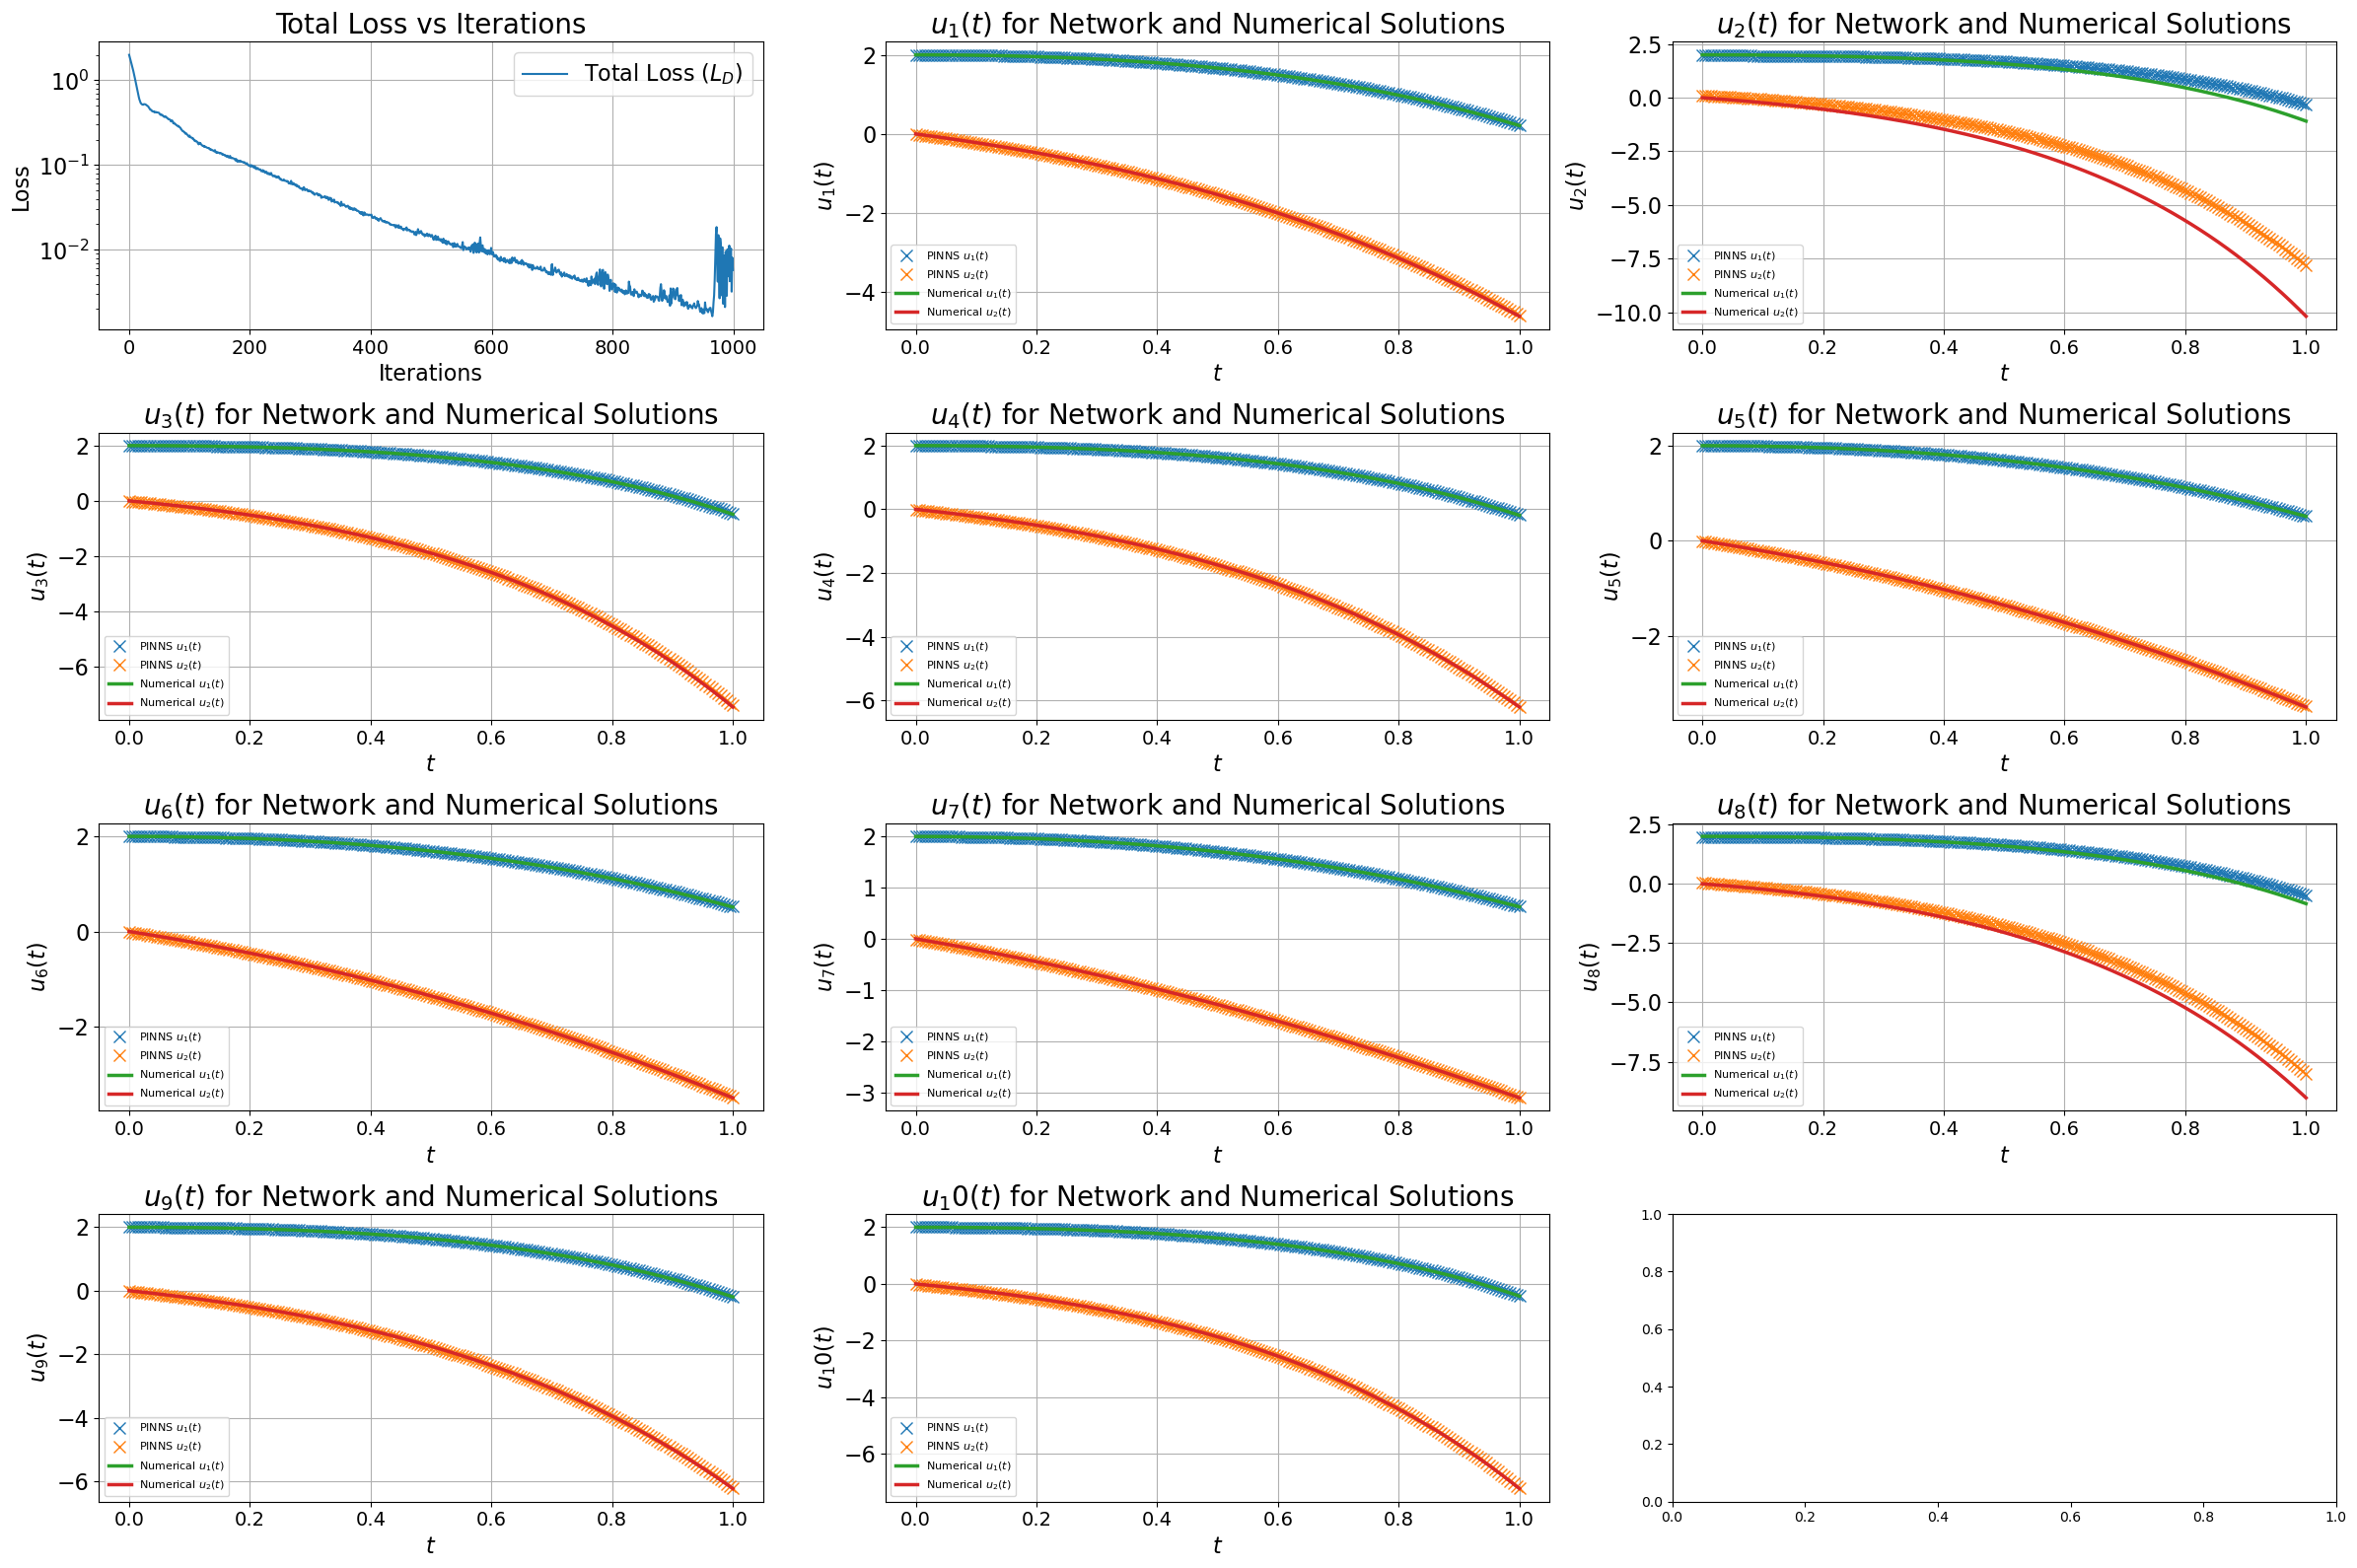

In [66]:
plot_loss_and_all_solution(x_range=x_range, true_functs=numerical_sol_fct,
                           trained_model=trained_model, v_list=IC_list, A_list=A_list,
                           force=force_list, train_losses=loss_hist['L_total'],
                           loss_label='Total Loss ($L_D$)', device=dev)

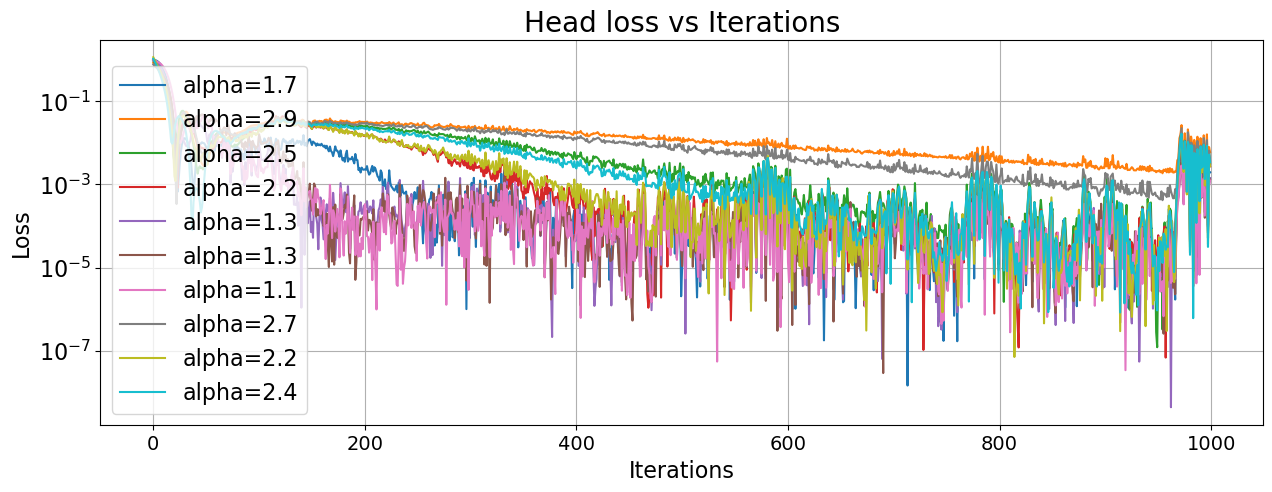

In [67]:
plot_head_loss(loss_hist["head"], alpha_list)

## One-Shot Transfer Learning

In [68]:
from src.transfer_learning import compute_H_and_dH_dt, analytically_compute_weights
from src.utils_plot import plot_transfer_learned_and_analytical

In [69]:
# forward pass to extract H, H0 and dH/dt
size = 512
H, H_0, dH_dt_new, t_eval = compute_H_and_dH_dt(x_range[0], x_range[1], trained_model, num_equations, hid_lay, size, dev)
H = H.double()
H_0 = H_0.double()
dH_dt_new = dH_dt_new.double()
t_eval = t_eval.double()

Time to compute H and dH_dt:  0.716 seconds


Time to compute weights (given H and dH_dt):  0.142 seconds
mean 0.0003479733543892393
max 0.0018058917877841196
mean 0.0017587944367717795
max 0.008835258906970012


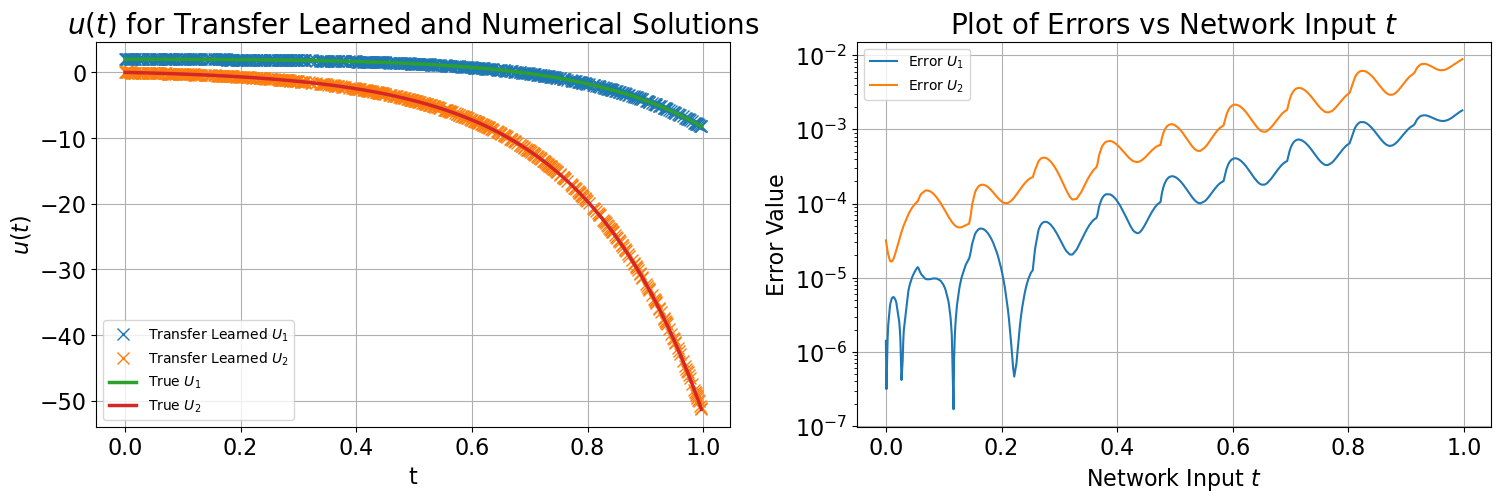

In [74]:
# Choose alpha, IC and force to transfer on
alpha_transfer = 5
A_transfer = get_A(alpha=alpha_transfer)
IC_transfer = IC_list[0].double()
force_transfer = force_list[0].double()

M_inv, W_out, force_terms, total_time = analytically_compute_weights(dH_dt_new, H, H_0, t_eval,
                                                                     IC_transfer, A_transfer,
                                                                     force_transfer, num_equations, dev)
plot_transfer_learned_and_analytical(H, W_out, t_eval, IC_transfer, A_transfer,
                                     force_transfer, num_equations, numerical_sol_fct)

## Try to Solve General Equation

In [96]:
alpha_transfer = 0; beta = 0.01

domain = (x_range[0], x_range[1]);
A_transfer = get_A(alpha=alpha_transfer)

def numerical_non_linear_solution(alpha, beta, u0, domain, t_eval):
  def F(t, y):
    return [y[1],
            alpha*(1 - beta*y[0]**2)*y[1] - y[0]]
  solution = solve_ivp(F, domain, u0, t_eval=t_eval)
  return solution
non_linear_num_sol = numerical_non_linear_solution(alpha_transfer, beta, IC_list[0].detach().cpu().squeeze(), domain, t_eval.detach().cpu().numpy().squeeze())

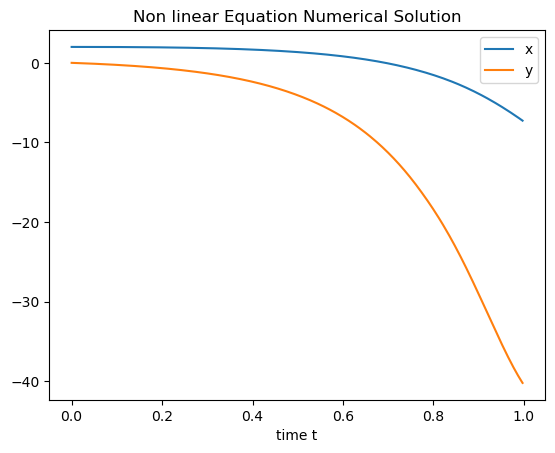

In [97]:
##plot the numerical solution
plt.plot(non_linear_num_sol.t, non_linear_num_sol.y[0], label='x');
plt.plot(non_linear_num_sol.t, non_linear_num_sol.y[1], label='y');
plt.xlabel("time t");
plt.title("Non linear Equation Numerical Solution");
plt.legend();

In [98]:
def compute_initial(x0, beta, p):
  denominator = 0
  for i in range(p+1):
    denominator += beta**i
  return x0/denominator

In [99]:
# functions to calculate the force function of each system p
def force_func_index(n):
    solution_index = [] # ind1, ind2, ind3, coeff
    for a in range(n+1):
        for b in range(a+1):
              for c in range(n+1):
                if ((a+b+c)==n):
                    if a==b:
                        solution_index.append([a, b, c, 1])
                    else:
                        solution_index.append([a, b, c, 2])
    return solution_index

def build_force_function(n):
    list_force_index = []
    for i in range(n+1):
        list_force_index.append(force_func_index(i))
    return list_force_index


def force_function_PINNS(i, list_force_index, alpha, PINNS_list):
      result = 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[-1]*(PINNS_list[force_ind[0]][:, 0, :]*PINNS_list[force_ind[1]][:, 0, :]*PINNS_list[force_ind[2]][:, 1, :])
      return torch.hstack((torch.zeros_like(result), -alpha*result))

def force_function_numerical(i, list_force_index, alpha, numerical_pert_list):
      result = 0
      for force_ind in list_force_index[i-1]:
        result += force_ind[-1]*(numerical_pert_list[force_ind[0]][0, :]*numerical_pert_list[force_ind[1]][0, :]*numerical_pert_list[force_ind[2]][1, :])
      return np.vstack((np.zeros_like(result), -alpha*result)).T


def solve_numericaly_perturbation(t, y, A, force, t_eval):
    index = np.argmin(np.abs(t_eval- t))
    return np.array([force[index, 0] - A[0][1] * y[1] - A[0][0] * y[0],
                     force[index, 1] - A[1][0] * y[0] - A[1][1] * y[1]])

numerical_perturbation_fct = lambda x, v, A, force: (solve_ivp(solve_numericaly_perturbation, [x_range[0], x_range[1]],
                                                    v.squeeze(), args=(A, force, x), t_eval=x.squeeze(), method="Radau").y)


In [100]:
import time
from src.transfer_learning import compute_M_inv, compute_W_with_IC_and_force


def solve_perturbation_TL(beta, p, t_eval,
                          alpha, A, force, IC, 
                          H, H_0, dH_dt, dev,
                          compute_numerical_pert,
                          verbose):

  # compute IC of the p systems
  x0_initials = compute_initial(IC[0], beta, p)
  v0_initials = compute_initial(IC[1], beta, p)
  IC_pertubation = torch.tensor([[x0_initials], [v0_initials]], device=dev)

  # compute the inverse of the M matrix associate with the equation
  if verbose:
    print(f"Solving the 0th linear ode system...")
  start_time = time.time()
  M_inv = compute_M_inv(dH_dt, H, H_0, t_eval, A, num_equations)
  total_time =  time.time() - start_time
  if verbose:
    print(f"Time to compute inverse of M: {total_time:.2e}")

  # compute the analytic W0 
  W0, comp_time = compute_W_with_IC_and_force(t_eval, A, IC_pertubation, force, H, H_0, dH_dt, num_equations, M_inv, dev)
  total_time += comp_time
  if verbose:
    print(f"Time to compute W0: {comp_time:.2e}")
    print("=======================================================")

  # store the solution in t_eval for the force function of next systems
  u0 = torch.matmul(H, W0)
  PINNS_list = [u0] 

  # compute numerical solution of the first system (numercial solution bu perturbation)
  if compute_numerical_pert:
    numerical_pert = numerical_sol_fct(t_eval.detach().cpu().numpy(),
                                       IC_pertubation.detach().cpu().numpy(),
                                       A.detach().cpu().numpy(), force)
    # store the numerical solution
    numerical_pert_list = [numerical_pert]
  
  # find the index of each systems force function 
  list_force_index = build_force_function(p)

  # solve the p systems
  for i in range(1, p+1):
    if verbose:
      print(f"Solving the {i}th linear ode system...")
         
    # compute the analytic Wi
    fi = force_function_PINNS(i, list_force_index, alpha, PINNS_list)
    Wi, computational_time = compute_W_with_IC_and_force(t_eval, A, IC_pertubation, fi, H, H_0, dH_dt, num_equations, M_inv, dev)
    total_time += computational_time

    if verbose:
      print(f"Time to compute W{i}: {computational_time:.2e}")
    # store the solution in t_eval for the force function of next systems
    ui = torch.matmul(H, Wi)
    PINNS_list.append(ui)

    if compute_numerical_pert:
      start_time = time.time()
      fi_numerical = force_function_numerical(i, list_force_index, alpha, numerical_pert_list) 
      numerical_pert_list.append(numerical_perturbation_fct(t_eval.detach().cpu(),
                                                            IC_pertubation.detach().cpu(),
                                                            A.detach().cpu(), fi_numerical))
      if verbose:
        print(f"Time to compute the perturbation numerical solution {time.time()-start_time:.2e}")

    if verbose:
      print("=======================================================")
  if verbose:
    print(f"{p+1} systems solved in {total_time:.3e} seconds")

  # Compute PINNS general perturbation solution 
  solution_PINNS = sum([beta**j*u for j, u in enumerate (PINNS_list)])
  solution_PINNS = solution_PINNS.detach().cpu().numpy().squeeze()
  # detach each solution of the p systems
  PINNS_list = [u.detach().cpu().numpy().squeeze() for u in PINNS_list]

  # Compute numerical general perturbation solution 
  if compute_numerical_pert:
    solution_numerical = sum([beta**j*u for j, u in enumerate (numerical_pert_list)]).T
    numerical_pert_list = [u.T for u in numerical_pert_list]
  else:
    solution_numerical = None
    numerical_pert_list = None

  return solution_PINNS, solution_numerical, PINNS_list, numerical_pert_list, total_time

In [101]:
p=5
compute_numerical_pert = True

solution_PINNS, \
solution_numerical, \
PINNS_list, \
numerical_pert_list, \
total_time = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                   alpha=alpha_transfer, A=A_transfer,
                                   force=force_transfer, IC=IC_transfer, 
                                   H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                   compute_numerical_pert=compute_numerical_pert,
                                   verbose=True)

Solving the 0th linear ode system...
Time to compute inverse of M: 2.62e-01
Time to compute W0: 0.00e+00
Solving the 1th linear ode system...
Time to compute W1: 0.00e+00
Time to compute the perturbation numerical solution 6.82e-01
Solving the 2th linear ode system...
Time to compute W2: 9.93e-04
Time to compute the perturbation numerical solution 1.18e+00
Solving the 3th linear ode system...
Time to compute W3: 0.00e+00
Time to compute the perturbation numerical solution 1.51e+00
Solving the 4th linear ode system...
Time to compute W4: 1.99e-03
Time to compute the perturbation numerical solution 1.49e+00
Solving the 5th linear ode system...
Time to compute W5: 0.00e+00
Time to compute the perturbation numerical solution 2.35e+00
6 systems solved in 2.652e-01 seconds


Text(0.5, 0.98, 'Solving non linear stiff ODE with $\\alpha=5$, $\\beta=0.01$, $p=5$')

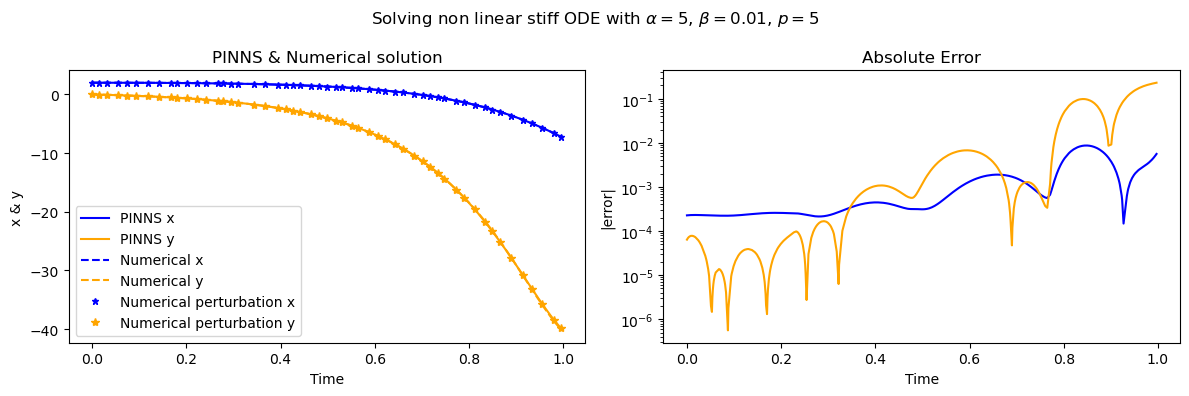

In [102]:
t_numpy = t_eval.detach().cpu().numpy()

fig, ax = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
# plot PINNS solution
ax[0].plot(t_numpy, solution_PINNS[:, 0], c='blue', label='PINNS x');
ax[0].plot(t_numpy, solution_PINNS[:, 1], c='orange', label='PINNS y');

# plot Numerical solution
ax[0].plot(t_numpy, non_linear_num_sol.y[0], '--', c='blue', label="Numerical x");
ax[0].plot(t_numpy, non_linear_num_sol.y[1], '--', c='orange', label="Numerical y");

# plot numerical solution by perturbation
if compute_numerical_pert:
    ax[0].plot(t_numpy[::10], solution_numerical[::10, 0], '*', c='blue', label='Numerical perturbation x', markersize=5)
    ax[0].plot(t_numpy[::10], solution_numerical[::10, 1], '*', c='orange', label='Numerical perturbation y')

ax[0].set_xlabel("Time");
ax[0].set_ylabel("x & y");
ax[0].legend(loc="best");
ax[0].set_title(fr"PINNS & Numerical solution")

# plot errors
ax[1].plot(t_numpy, np.abs(solution_PINNS[:, 0]-non_linear_num_sol.y[0]), c='blue', label='error x');
ax[1].plot(t_numpy, np.abs(solution_PINNS[:, 1]-non_linear_num_sol.y[1]), c='orange', label='error y');
ax[1].set_yscale('log')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('|error|')
ax[1].set_title('Absolute Error')

fig.suptitle(fr"Solving non linear stiff ODE with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")


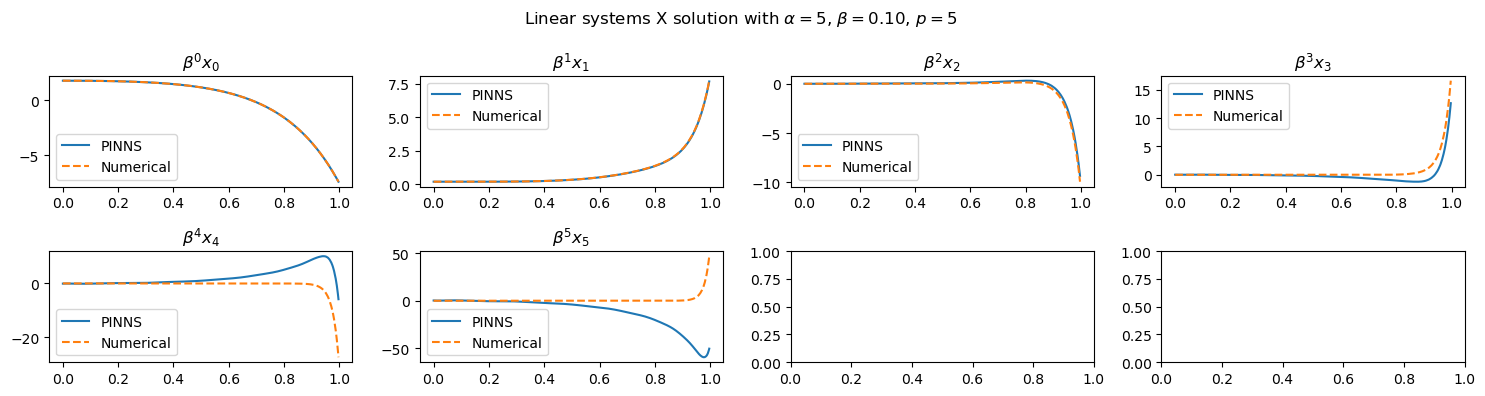

In [95]:
nb_row_plot = (p+1)//4+1 if (p+1)%4!=0 else (p+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_numpy, PINNS_list[i][:, 0]*pert_coeff, label="PINNS")
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, numerical_pert_list[i][:, 0]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(rf"$\beta^{i} x_{i}$")
  ax[j][k].legend(loc="best")
fig.suptitle(fr"Linear systems X solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
fig.tight_layout()

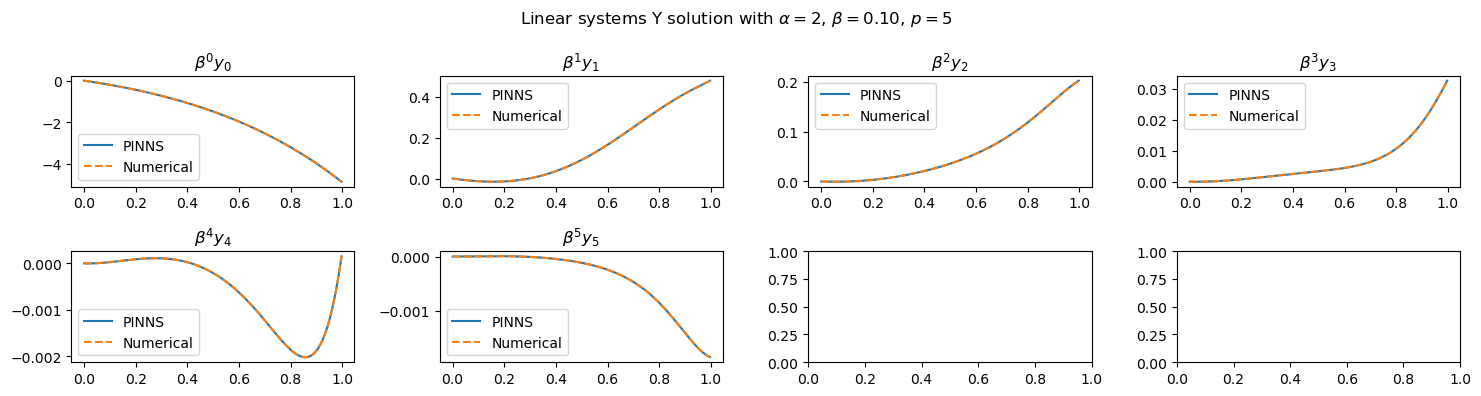

In [84]:
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2))
for i in range(p+1):
  j = i//4; k = i%4
  pert_coeff = (beta)**i
  ax[j][k].plot(t_numpy, PINNS_list[i][:, 1]*pert_coeff, label="PINNS")
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, numerical_pert_list[i][:, 1]*pert_coeff, '--', label="Numerical")
  ax[j][k].set_title(rf"$\beta^{i} y_{i}$")
  ax[j][k].legend(loc="best")
fig.suptitle(fr"Linear systems Y solution with $\alpha={alpha_transfer}$, $\beta={beta:.2f}$, $p={p}$")
fig.tight_layout()

In [85]:
#p_list = [i for i in range(0, 20, 3)]
p_list = [i for i in range(0, 20)]
compute_numerical_pert = False
sol_PINNS_list =[]
sol_PINNS_list_list =[]
sol_num_list = []
sol_num_list_list = []
total_time_list = []
for p in p_list:
  print("Solving p = {}".format(p))
  sp, \
  sn, \
  sp_list, \
  sn_list, \
  tt = solve_perturbation_TL(beta=beta, p=p, t_eval=t_eval,
                                     alpha=alpha_transfer, A=A_transfer,
                                                     force=force_transfer, IC=IC_transfer, 
                                                     H=H, H_0=H_0, dH_dt=dH_dt_new, dev=dev,
                                                     compute_numerical_pert=compute_numerical_pert,
                                                     verbose=False)
  sol_PINNS_list.append(sp)
  sol_num_list.append(sn)
  sol_PINNS_list_list.append(sp_list)
  sol_num_list_list.append(sn_list)
  total_time_list.append(tt)

Solving p = 0
Solving p = 1
Solving p = 2
Solving p = 3
Solving p = 4
Solving p = 5
Solving p = 6
Solving p = 7
Solving p = 8
Solving p = 9
Solving p = 10
Solving p = 11
Solving p = 12
Solving p = 13
Solving p = 14
Solving p = 15
Solving p = 16
Solving p = 17
Solving p = 18
Solving p = 19


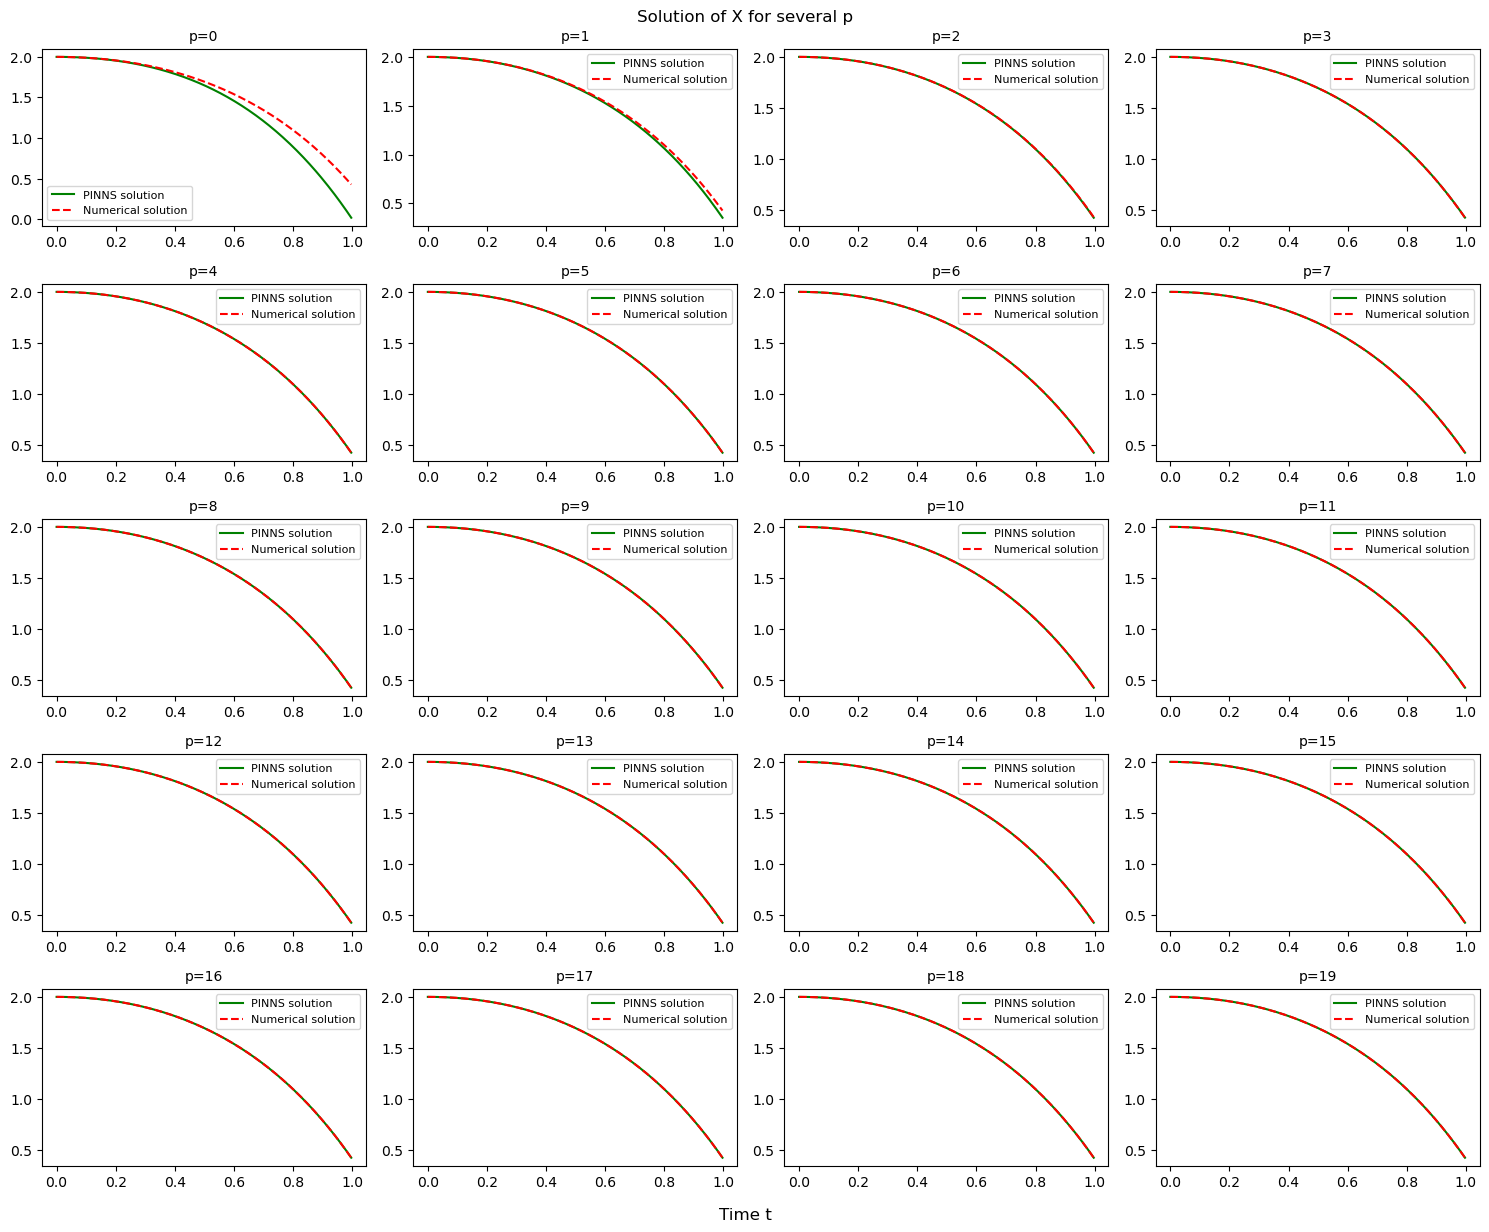

In [86]:
# Numerical - Numerical Perturbation X
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  ax[j][k].plot(t_numpy, sol_PINNS_list[i][:, 0], 'g', label='PINNS solution')
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, sol_num_list[i][:, 0], '--', label='Numerical solution by perturbation')
  ax[j][k].plot(t_numpy, non_linear_num_sol.y[0], '--r', label='Numerical solution')
  ax[j][k].legend(fontsize=8)
  ax[j][k].set_title(f"p={p_list[i]}", fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Solution of X for several p");
fig.tight_layout()

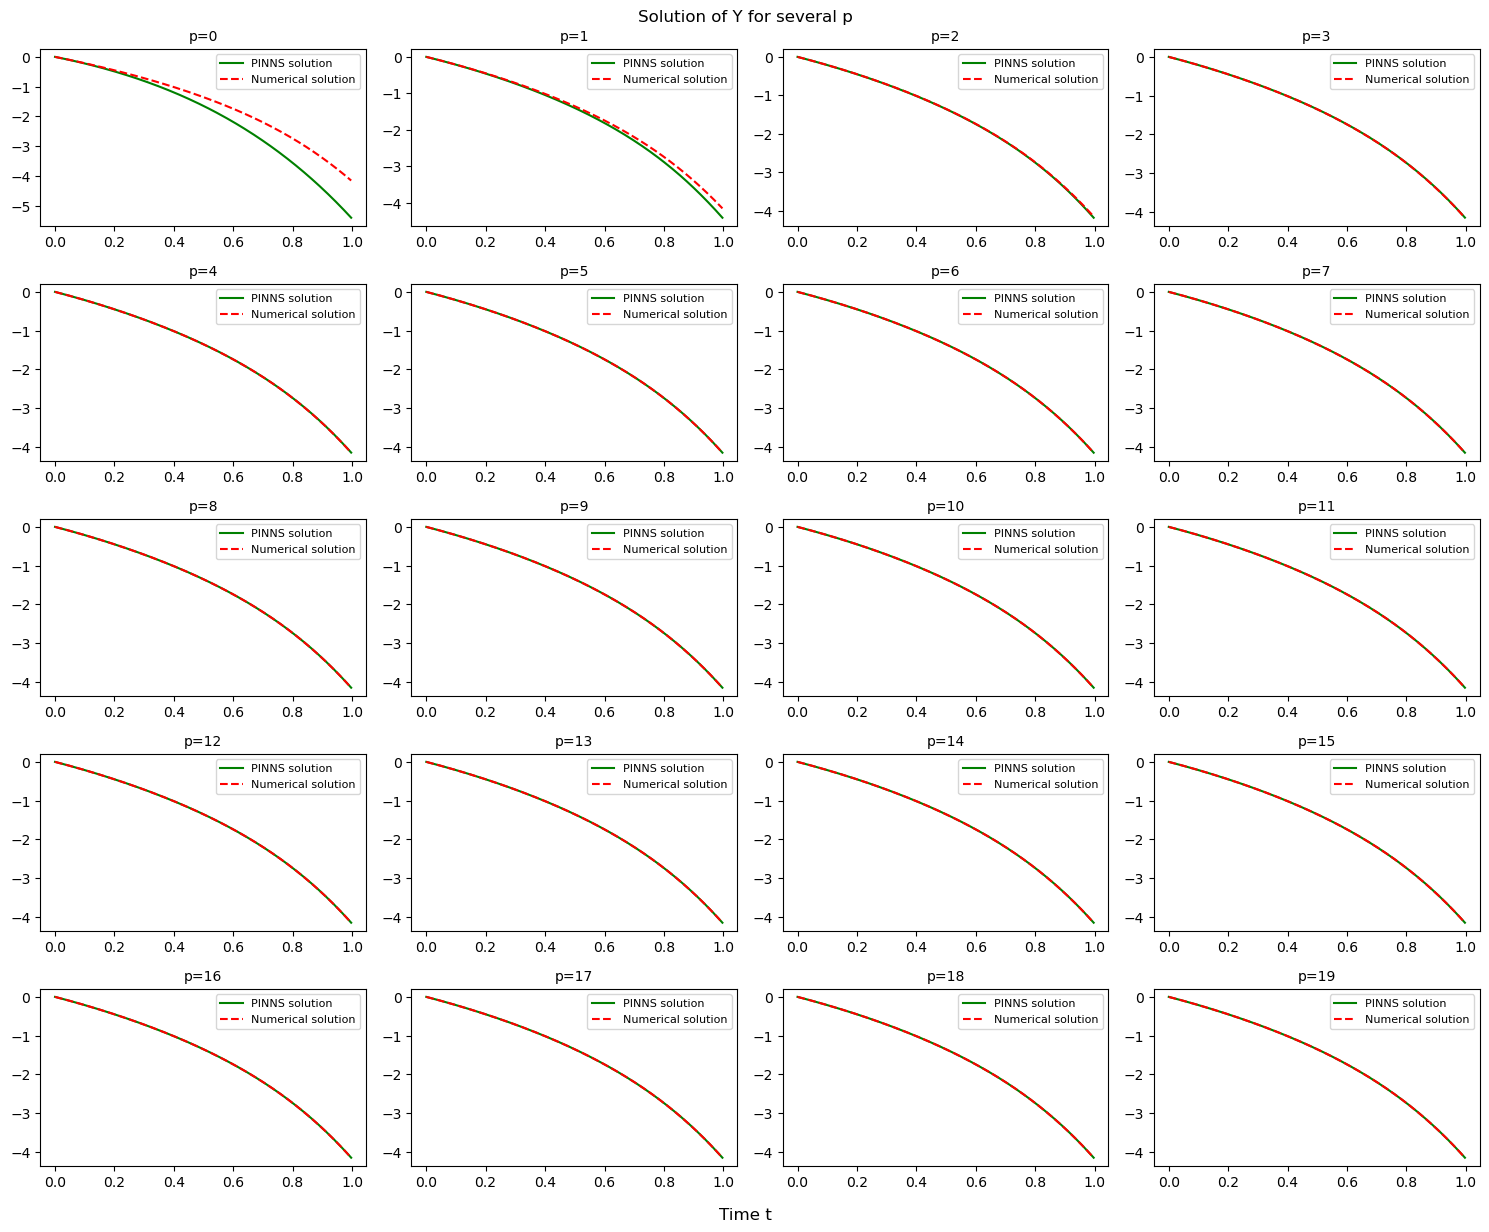

In [87]:
# Numerical - Numerical Perturbation Y
nb_row_plot = (len(p_list)+1)//4+1 if (len(p_list))%4!=0 else (len(p_list)+1)//4
fig, ax = plt.subplots(nb_row_plot, 4, figsize=(15, nb_row_plot*2.5))
for i in range(len(p_list)):
  j = i//4; k = i%4
  ax[j][k].plot(t_numpy, sol_PINNS_list[i][:, 1], 'g', label='PINNS solution')
  if compute_numerical_pert:
    ax[j][k].plot(t_numpy, sol_num_list[i][:, 1], '--', label='Numerical solution by perturbation')
  ax[j][k].plot(t_numpy, non_linear_num_sol.y[1], '--r', label='Numerical solution')
  ax[j][k].legend(fontsize=8)
  ax[j][k].set_title(f"p={p_list[i]}", fontsize=10)
fig.supxlabel("Time t");
fig.suptitle("Solution of Y for several p");
fig.tight_layout()

# END